In [21]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
#Load in Training and Test Data
train_data = pd.read_csv('train_dataset.csv')
test_data = pd.read_csv('test_dataset.csv')

# Separate Training data into attributes and labels
X = train_data.iloc[:, :-1]
y = train_data.iloc[:, -1]

In [23]:
# Save id column for later csv creation
id_col = test_data['id']
# Remove nominal/categorical data from both sets
numeric_attributes = X.select_dtypes(include='number').columns

X = X[numeric_attributes]
test_data = test_data[numeric_attributes]

In [24]:
#chosen_model = GradientBoostingClassifier()
#chosen_model = RandomForestClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=150)

In [25]:
chosen_model.fit(X, y)

AdaBoostClassifier()

In [26]:
# Evaluate performance of model using k-folds cross validation
k_folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(chosen_model, X, y, cv=k_folds)

print("K-Folds Accuracies:", cv_scores)
print("K-Folds Mean Accuracy:", cv_scores.mean())

K-Folds Accuracies: [0.55813953 0.35215947 0.39534884 0.48837209 0.47333333 0.49333333
 0.49333333 0.55333333 0.53333333 0.6       ]
K-Folds Mean Accuracy: 0.49406866002214833


In [20]:
# Train and make test set predictions for Kaggle
predictions = chosen_model.predict(test_data)
predictions_df = pd.DataFrame({'id': id_col, 'imdb_score_binned': predictions})
predictions_df.to_csv('predictions.csv', index=False)

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Grid Search to tune hyperparameters
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2, 0,5, 1.0],
}

# Perform grid search
grid_search = GridSearchCV(chosen_model, param_grid=param_grid, cv=k_folds, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

Best Hyperparameters: {'learning_rate': 0.2, 'n_estimators': 50}
Best Score: 0.6408488934993085


c:\Users\j_awe\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\j_awe\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\j_awe\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 124, in fit
    self._validate_params()
  File "c:\Users\j_awe\anaconda3\Lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\j_awe\anaconda3\Lib\si

Confusion Matrix:
[[  0   1   4   0   0]
 [  0   8  40   0   0]
 [  0   3 342  32   0]
 [  0   1  68  76   7]
 [  0   0   1   7  11]]


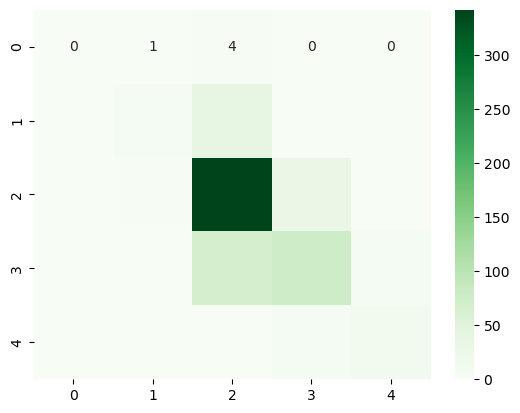

In [15]:
# Use a confusion matrix to get performance
chosen_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = chosen_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

sns.heatmap(cm, cmap='Greens', annot=True, fmt='d')
plt.show()